# Example: How PyRayHF works
This Notebook shows how Vertical PyRAY works and helps to visualize the code flow.

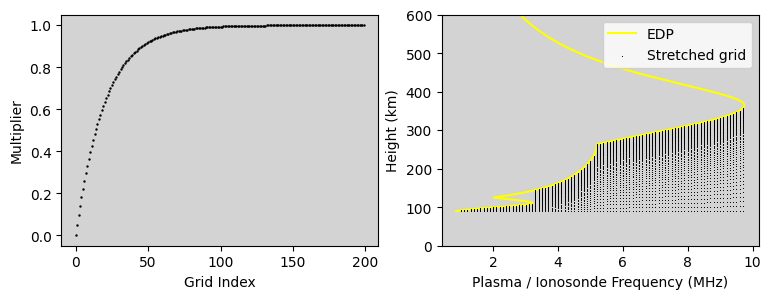

In [1]:
#!/usr/bin/env python
# --------------------------------------------------------
# Distribution Statement A. Approved for public release.
# Distribution is unlimited.
# This work was supported by the Office of Naval Research.
# --------------------------------------------------------
"""Example of work flow in PyRayHF.
"""

import pickle
import numpy as np
import matplotlib.pyplot as plt
import PyRayHF

# Load input arrays from the example.
# See Example_Generate_Input_Arrays for how to create input arrays using PyIRI.
file_open = 'Example_input.p'
input_arrays = pickle.load(open(file_open, 'rb'))

# Compute virtual height for the ordinary 'O' propagation mode.
# A low number of vertical grid points is sufficient for O-mode (e.g., 200).
mode = 'O'
n_points = 200

# Limit the ionosonde frequency array up tp the ionospheric critical
# frequency foF2 and convert form MHz to Hz.
foF2 = np.max(PyRayHF.library.den2freq(input_arrays['den']))

# Index where ionosonde frequency is less then foF2 value
ind = np.where((input_arrays['freq'] * 1e6) < foF2)

# Select ionosonde frequency with this criteria
freq_lim = input_arrays['freq'][ind] * 1e6

# Make empty array to collect virtual height of the same size as input
# frequency array
vh = np.zeros((input_arrays['freq'].size)) + np.nan

# Interpolate input arrays into a new stretched grid based on the
# reflective height for each ionosonde frequency
# Frequency needs to be converted to MHz from Hz
regridded = PyRayHF.library.regrid_to_nonuniform_grid(freq_lim,
                                                      input_arrays['den'],
                                                      input_arrays['bmag'],
                                                      input_arrays['bpsi'],
                                                      input_arrays['alt'],
                                                      n_points)

# Plot visualization of the new stretched grid
# The electron density profile (EDP) is converted from plasma density to plasma
# frequency.
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(9, 3)
ax_plot = ax[0]
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Multiplier')
ax_plot.set_xlabel('Grid Index')
ax_plot.scatter(np.arange(0, n_points), PyRayHF.library.smooth_nonuniform_grid(0, 1, n_points, 10), c='black', linewidth=0, s=3)

ax_plot = ax[1]
ax_plot.set_ylim([0, 600])
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Height (km)')
ax_plot.set_xlabel('Plasma / Ionosonde Frequency (MHz)')
ax_plot.plot(PyRayHF.library.den2freq(input_arrays['den']) / 1e6, input_arrays['alt'],
        c='yellow', label='EDP', zorder=1)
ax_plot.scatter(regridded['freq'] / 1e6, regridded['alt'], c='black', linewidth=0, s=0.5, label='Stretched grid')
plt.legend()

Plot visualization of the interpolated to the new grid input arrays

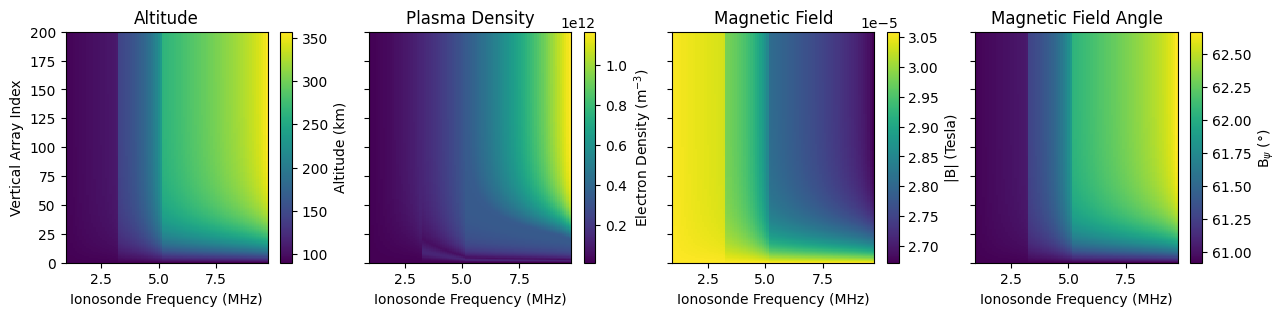

In [2]:
fig, ax = plt.subplots(1, 4, sharey=True, sharex=True)
fig.set_size_inches(15, 3)

ax_plot = ax[0]
ax_plot.set_ylim([0, 200])
ax_plot.set_title('Altitude')
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Vertical Array Index')
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], regridded['alt'])
cbar = fig.colorbar(mesh, ax=ax_plot)
cbar.set_label('Altitude (km)')

ax_plot = ax[1]
ax_plot.set_ylim([0, 200])
ax_plot.set_title('Plasma Density')
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], regridded['den'])
cbar = fig.colorbar(mesh, ax=ax_plot)
cbar.set_label('Electron Density (m$^{-3}$)')

ax_plot = ax[2]
ax_plot.set_ylim([0, 200])
ax_plot.set_title('Magnetic Field')
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], regridded['bmag'])
cbar = fig.colorbar(mesh, ax=ax_plot)
cbar.set_label('|B| (Tesla)')

ax_plot = ax[3]
ax_plot.set_ylim([0, 200])
ax_plot.set_title('Magnetic Field Angle')
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], regridded['bpsi'])
cbar = fig.colorbar(mesh, ax=ax_plot)
cbar.set_label('B$_ψ$ (°)')


Plot intermediate calculations for: the the ratio of the square of the plasma frequency f_N to the square of the ionosonde frequency f (X), the ratio of electron gyrofrequency and the ionosonde frequency (Y), the phase refractive index (μ), and the group refractive index (μ′)

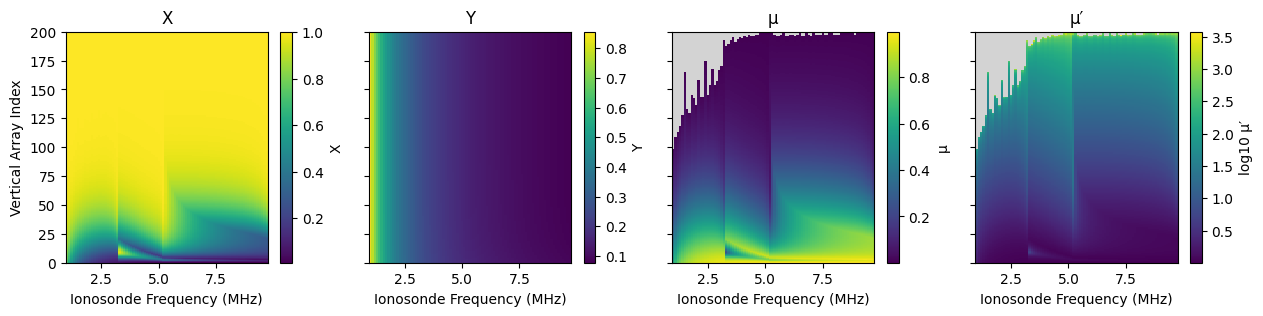

In [3]:
# Find the ratio of the square of the plasma frequency f_N to the square of
# the ionosonde frequency f.
aX = PyRayHF.library.find_X(regridded['den'], regridded['freq'])

# Find the ratio of electron gyrofrequency and the ionosonde frequency
aY = PyRayHF.library.find_Y(regridded['freq'], regridded['bmag'])

# Find the phase refractive index μ and the group refractive index μ′
mu, mup = PyRayHF.library.find_mu_mup(aX, aY, regridded['bpsi'], mode)

# Plot visualization of the X and Y raytracing variables
fig, ax = plt.subplots(1, 4, sharey=True, sharex=True)
fig.set_size_inches(15, 3)
ax_plot = ax[0]
ax_plot.set_ylim([0, 200])
ax_plot.set_title('X')
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Vertical Array Index')
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], aX)
cbar = fig.colorbar(mesh, ax=ax_plot)
cbar.set_label('X')

ax_plot = ax[1]
ax_plot.set_ylim([0, 200])
ax_plot.set_title('Y')
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], aY)
cbar = fig.colorbar(mesh, ax=ax_plot)
cbar.set_label('Y')

ax_plot = ax[2]
ax_plot.set_ylim([0, 200])
ax_plot.set_title('μ')
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], mu)
cbar = fig.colorbar(mesh, ax=ax_plot)
cbar.set_label('μ')

ax_plot = ax[3]
ax_plot.set_ylim([0, 200])
ax_plot.set_title('μ′')
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Ionosonde Frequency (MHz)')
mesh = ax_plot.pcolormesh(regridded['freq'] / 1e6, regridded['ind'], np.log10(mup))
cbar = fig.colorbar(mesh, ax=ax_plot)
cbar.set_label('log10 μ′')

The virtual height is the integral of μ′, or the multiplication of the μ′ matrix with the matrix that contains distances between the vertical grid points.

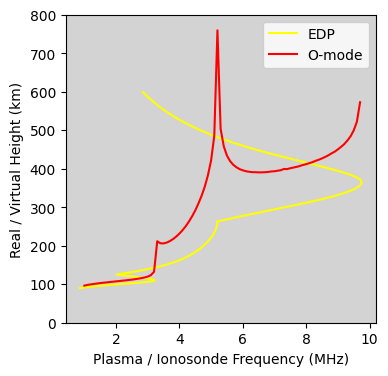

In [4]:
# Find virtual height as vertical integral through μ′
vh[ind] = np.nansum(mup * regridded['dist'], axis=1) + np.min(input_arrays['alt'])

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_ylim([0, 800])
ax.set_facecolor("lightgray")
ax.set_ylabel('Real / Virtual Height (km)')
ax.set_xlabel('Plasma / Ionosonde Frequency (MHz)')
ax.plot(PyRayHF.library.den2freq(input_arrays['den']) / 1e6, input_arrays['alt'],
        c='yellow', label='EDP', zorder=1)
ax.plot(input_arrays['freq'], vh, c='red', label='O-mode', zorder=2)
plt.legend()